# Calculate Rotational Invariance Loss for Checkpoints

This notebook loads a list of checkpoints and calculates their rotational invariance loss using 100 random rotations each.


In [1]:
# Core imports
import sys
sys.path.append('../..')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# XFADS imports
import xfads.utils as utils
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

# Custom modules
from regularized_ssm import RegularizedSSM, create_rotation_vector_field
from regularizers import RotationInvarianceRegularizer

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print("📊 Environment ready!")

Using device: cpu
📊 Environment ready!


In [2]:
def load_ssm_from_checkpoint(checkpoint_path, n_latents=2, n_neurons=100, device='cpu'):
    """
    Load SSM model from checkpoint for rotational invariance evaluation.
    
    Args:
        checkpoint_path: Path to the .pt checkpoint file
        n_latents: Number of latent dimensions
        n_neurons: Number of neurons/observations
        device: Device to load on
        
    Returns:
        dynamics_fn: The dynamics function for evaluation
        checkpoint_info: Dictionary with checkpoint metadata
    """
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Basic configuration that works for most checkpoints
    cfg = {
        'n_latents': n_latents,
        'n_latents_read': n_latents,  
        'n_hidden_dynamics': 32,
        'n_hidden_local': 32,
        'n_hidden_backward': 32,
        'rank_local': 2,
        'rank_backward': 2,
        'p_local_dropout': 0.0,
    }
    
    # Create minimal model components
    C = utils.FanInLinear(cfg['n_latents'], n_neurons, device=device).requires_grad_(False)
    Q_diag = 5e-3 * torch.ones(cfg['n_latents'], device=device)
    Q_0_diag = 1.0 * torch.ones(cfg['n_latents'], device=device)
    R_diag = 1e-1 * torch.ones(n_neurons, device=device)
    m_0 = torch.zeros(cfg['n_latents'], device=device)
    
    H = utils.ReadoutLatentMask(cfg['n_latents'], cfg['n_latents_read'])
    readout_fn = nn.Sequential(H, C)
    likelihood_pdf = GaussianLikelihood(readout_fn, n_neurons, R_diag, device=device, fix_R=True)

    dynamics_fn = utils.build_gru_dynamics_function(cfg['n_latents'], cfg['n_hidden_dynamics'], device=device)
    dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg['n_latents'], Q_diag, device=device)

    initial_condition_pdf = DenseGaussianInitialCondition(cfg['n_latents'], m_0, Q_0_diag, device=device)

    backward_encoder = BackwardEncoderLRMvn(
        cfg['n_latents'], cfg['n_hidden_backward'], cfg['n_latents'],
        rank_local=cfg['rank_local'], rank_backward=cfg['rank_backward'], device=device
    )
    local_encoder = LocalEncoderLRMvn(
        cfg['n_latents'], n_neurons, cfg['n_hidden_local'], cfg['n_latents'],
        rank=cfg['rank_local'], device=device, dropout=cfg['p_local_dropout']
    )

    nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=device)

    # Create minimal RegularizedSSM without regularizers for loading
    ssm = RegularizedSSM(
        dynamics_mod=dynamics_mod,
        likelihood_pdf=likelihood_pdf,
        initial_c_pdf=initial_condition_pdf,
        backward_encoder=backward_encoder,
        local_encoder=local_encoder,
        nl_filter=nl_filter,
        target_vector_field=None,
        lambda_lie=0.0,
        lambda_curvature=0.0,
        lambda_rotation=0.0,
        device=device
    )
    
    # Load the trained weights
    try:
        ssm.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print(f"✅ Loaded model from {Path(checkpoint_path).name}")
    except Exception as e:
        print(f"⚠️ Warning loading {Path(checkpoint_path).name}: {e}")
        # Try loading only dynamics parameters
        state_dict = checkpoint['model_state_dict']
        dynamics_keys = [k for k in state_dict.keys() if 'dynamics_mod' in k]
        if dynamics_keys:
            dynamics_state = {k: v for k, v in state_dict.items() if k in dynamics_keys}
            ssm_dict = ssm.state_dict()
            ssm_dict.update(dynamics_state)
            ssm.load_state_dict(ssm_dict, strict=False)
            print(f"✅ Partial loading successful ({len(dynamics_keys)} parameters)")
    
    ssm.eval()
    
    # Extract checkpoint info
    checkpoint_info = {
        'experiment_name': checkpoint.get('experiment_name', 'unknown'),
        'epoch': checkpoint.get('epoch', 'unknown'),
        'metrics': checkpoint.get('metrics', {}),
        'checkpoint_path': checkpoint_path
    }
    
    return ssm.dynamics_mod.mean_fn, checkpoint_info


def calculate_rotation_invariance_loss(dynamics_fn, n_rotations=100, n_test_points=1000, 
                                     test_radius=2.0, device='cpu', random_seed=42):
    """
    Calculate rotational invariance loss for a dynamics function.
    
    Args:
        dynamics_fn: The dynamics function to evaluate
        n_rotations: Number of random rotations to sample
        n_test_points: Number of test points to sample
        test_radius: Radius for sampling test points
        device: Device for computation
        random_seed: Random seed for reproducibility
        
    Returns:
        mean_loss: Mean rotational invariance loss across all test points and rotations
        std_loss: Standard deviation of the loss
        all_losses: All individual loss values for detailed analysis
    """
    if random_seed is not None:
        torch.manual_seed(random_seed)
    
    # Create rotation invariance regularizer
    rot_regularizer = RotationInvarianceRegularizer(dynamics_fn, n_rotations=n_rotations)
    
    # Sample test points uniformly within a circle
    # Use rejection sampling for uniform distribution in circle
    test_points = []
    while len(test_points) < n_test_points:
        # Sample in square then reject points outside circle
        candidates = test_radius * (2 * torch.rand(n_test_points * 2, 2, device=device) - 1)
        # Keep points within circle
        norms = torch.linalg.norm(candidates, dim=-1)
        valid_points = candidates[norms <= test_radius]
        test_points.append(valid_points)
        if len(test_points) > 10:  # Prevent infinite loop
            break
    
    test_points = torch.cat(test_points, dim=0)[:n_test_points]
    
    # Calculate rotational invariance loss
    with torch.no_grad():
        # eval_regularizer returns loss for each point
        point_losses = rot_regularizer.eval_regularizer(test_points)  # Shape: (n_test_points,)
        
        mean_loss = point_losses.mean().item()
        std_loss = point_losses.std().item()
        all_losses = point_losses.cpu().numpy()
    
    return mean_loss, std_loss, all_losses


print("🔧 Helper functions defined:")
print("   - load_ssm_from_checkpoint(): Load dynamics function from checkpoint")
print("   - calculate_rotation_invariance_loss(): Compute rotational invariance loss")

🔧 Helper functions defined:
   - load_ssm_from_checkpoint(): Load dynamics function from checkpoint
   - calculate_rotation_invariance_loss(): Compute rotational invariance loss


In [7]:
def evaluate_checkpoints_rotation_invariance(checkpoint_paths, n_rotations=100, 
                                           n_test_points=1000, test_radius=1.0,
                                           save_results=True, results_filename='rotation_invariance_results.csv'):
    """
    Evaluate rotational invariance loss for a list of checkpoints.
    
    Args:
        checkpoint_paths: List of paths to checkpoint files
        n_rotations: Number of rotations to sample per evaluation
        n_test_points: Number of test points per evaluation
        test_radius: Radius for sampling test points
        save_results: Whether to save results to CSV
        results_filename: Filename for saved results
        
    Returns:
        results_df: DataFrame with results
    """
    results = []
    
    print(f"🔄 Evaluating {len(checkpoint_paths)} checkpoints with {n_rotations} rotations each...")
    print(f"   Using {n_test_points} test points within radius {test_radius}")
    print("="*60)
    
    for i, checkpoint_path in enumerate(checkpoint_paths):
        try:
            # Load dynamics function
            dynamics_fn, checkpoint_info = load_ssm_from_checkpoint(checkpoint_path, device=device)
            
            # Calculate rotational invariance loss
            mean_loss, std_loss, all_losses = calculate_rotation_invariance_loss(
                dynamics_fn, 
                n_rotations=n_rotations,
                n_test_points=n_test_points,
                test_radius=test_radius,
                device=device
            )
            
            # Store results
            result = {
                'checkpoint_path': checkpoint_path,
                'checkpoint_name': Path(checkpoint_path).name,
                'experiment_name': checkpoint_info['experiment_name'],
                'epoch': checkpoint_info['epoch'],
                'mean_rotation_loss': mean_loss,
                'std_rotation_loss': std_loss,
                'min_rotation_loss': np.min(all_losses),
                'max_rotation_loss': np.max(all_losses),
                'median_rotation_loss': np.median(all_losses),
                'n_rotations': n_rotations,
                'n_test_points': n_test_points,
                'test_radius': test_radius
            }
            
            results.append(result)
            
            print(f"[{i+1:2d}/{len(checkpoint_paths)}] {Path(checkpoint_path).name}")
            print(f"         Experiment: {checkpoint_info['experiment_name']}")
            print(f"         Rotation Loss: {mean_loss:.6f} ± {std_loss:.6f}")
            print(f"         Range: [{np.min(all_losses):.6f}, {np.max(all_losses):.6f}]")
            
        except Exception as e:
            print(f"❌ [{i+1:2d}/{len(checkpoint_paths)}] Failed to process {Path(checkpoint_path).name}: {e}")
            continue
        
        print("-" * 60)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    if len(results) > 0:
        print(f"\n📊 Summary of {len(results)} successful evaluations:")
        print(f"   Mean rotation loss: {results_df['mean_rotation_loss'].mean():.6f}")
        print(f"   Std of means: {results_df['mean_rotation_loss'].std():.6f}")
        print(f"   Range: [{results_df['mean_rotation_loss'].min():.6f}, {results_df['mean_rotation_loss'].max():.6f}]")
        
        # Find best and worst
        best_idx = results_df['mean_rotation_loss'].idxmin()
        worst_idx = results_df['mean_rotation_loss'].idxmax()
        
        print(f"\n🏆 Best (lowest loss): {results_df.loc[best_idx, 'checkpoint_name']}")
        print(f"   Loss: {results_df.loc[best_idx, 'mean_rotation_loss']:.6f}")
        print(f"   Experiment: {results_df.loc[best_idx, 'experiment_name']}")
        
        print(f"\n🚨 Worst (highest loss): {results_df.loc[worst_idx, 'checkpoint_name']}")
        print(f"   Loss: {results_df.loc[worst_idx, 'mean_rotation_loss']:.6f}")
        print(f"   Experiment: {results_df.loc[worst_idx, 'experiment_name']}")
        
        # Save results
        if save_results:
            results_df.to_csv(results_filename, index=False)
            print(f"\n💾 Results saved to: {results_filename}")
    else:
        print("❌ No successful evaluations!")
    
    return results_df


print("📊 Main evaluation function defined:")
print("   - evaluate_checkpoints_rotation_invariance(): Batch evaluate multiple checkpoints")

📊 Main evaluation function defined:
   - evaluate_checkpoints_rotation_invariance(): Batch evaluate multiple checkpoints


In [16]:
# Example: Define your checkpoint paths here
checkpoint_paths = [
    "/Users/artliang/Documents/symm_reg/in_progress/ckpts_rotation_invariance/perturb_test_rotation_lambda_0_00e00_final_epoch_025.pt",
    "/Users/artliang/Documents/symm_reg/in_progress/ckpts_rotation_invariance/perturb_test_rotation_lambda_1_00eneg05_final_epoch_025.pt",
    "/Users/artliang/Documents/symm_reg/in_progress/ckpts_rotation_invariance/perturb_test_rotation_lambda_1_00eneg03_final_epoch_025.pt",
    "/Users/artliang/Documents/symm_reg/in_progress/ckpts_rotation_invariance/perturb_test_rotation_lambda_1_00eneg01_final_epoch_025.pt",
    "/Users/artliang/Documents/symm_reg/in_progress/ckpts_rotation_invariance/perturb_test_rotation_lambda_1_00e01_final_epoch_025.pt",
    "/Users/artliang/Documents/symm_reg/in_progress/ckpts_rotation_invariance/perturb_test_rotation_lambda_1_00e03_final_epoch_025.pt",
]

# Filter to only existing files
existing_paths = []
for path in checkpoint_paths:
    if Path(path).exists():
        existing_paths.append(path)
    else:
        print(f"⚠️  File not found: {Path(path).name}")

print(f"\n📁 Found {len(existing_paths)} existing checkpoint files:")
for path in existing_paths:
    print(f"   - {Path(path).name}")

if len(existing_paths) > 0:
    print(f"\n🚀 Ready to evaluate {len(existing_paths)} checkpoints!")
    print("   Run the next cell to start evaluation.")
else:
    print("\n❌ No valid checkpoint files found. Please update the checkpoint_paths list.")
    print("\n💡 Example of how to add your checkpoints:")
    print("   checkpoint_paths = [")
    print('       "/path/to/your/checkpoint1.pt",') 
    print('       "/path/to/your/checkpoint2.pt",') 
    print("   ]")


📁 Found 6 existing checkpoint files:
   - perturb_test_rotation_lambda_0_00e00_final_epoch_025.pt
   - perturb_test_rotation_lambda_1_00eneg05_final_epoch_025.pt
   - perturb_test_rotation_lambda_1_00eneg03_final_epoch_025.pt
   - perturb_test_rotation_lambda_1_00eneg01_final_epoch_025.pt
   - perturb_test_rotation_lambda_1_00e01_final_epoch_025.pt
   - perturb_test_rotation_lambda_1_00e03_final_epoch_025.pt

🚀 Ready to evaluate 6 checkpoints!
   Run the next cell to start evaluation.


In [19]:
# Run the evaluation
if len(existing_paths) > 0:
    # Main evaluation with 100 rotations
    results_df = evaluate_checkpoints_rotation_invariance(
        existing_paths,
        n_rotations=1,
        n_test_points=1000,
        test_radius=1.0,
        save_results=True,
        results_filename='checkpoint_rotation_invariance_analysis.csv'
    )
    
    # Display the results table
    if len(results_df) > 0:
        print("\n📋 Detailed Results:")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        print(results_df[['checkpoint_name', 'experiment_name', 'mean_rotation_loss', 
                         'std_rotation_loss', 'min_rotation_loss', 'max_rotation_loss']].to_string(index=False))
else:
    print("⚠️ No checkpoints to evaluate. Please update the checkpoint paths in the previous cell.")

🔄 Evaluating 6 checkpoints with 1 rotations each...
   Using 1000 test points within radius 1.0
✅ Loaded model from perturb_test_rotation_lambda_0_00e00_final_epoch_025.pt
[ 1/6] perturb_test_rotation_lambda_0_00e00_final_epoch_025.pt
         Experiment: perturb_test_rotation_lambda_0_00e00
         Rotation Loss: 0.000933 ± 0.000629
         Range: [0.000002, 0.002572]
------------------------------------------------------------
✅ Loaded model from perturb_test_rotation_lambda_1_00eneg05_final_epoch_025.pt
[ 2/6] perturb_test_rotation_lambda_1_00eneg05_final_epoch_025.pt
         Experiment: perturb_test_rotation_lambda_1_00eneg05
         Rotation Loss: 0.000675 ± 0.000592
         Range: [0.000001, 0.002439]
------------------------------------------------------------
✅ Loaded model from perturb_test_rotation_lambda_1_00eneg03_final_epoch_025.pt
[ 3/6] perturb_test_rotation_lambda_1_00eneg03_final_epoch_025.pt
         Experiment: perturb_test_rotation_lambda_1_00eneg03
         Ro

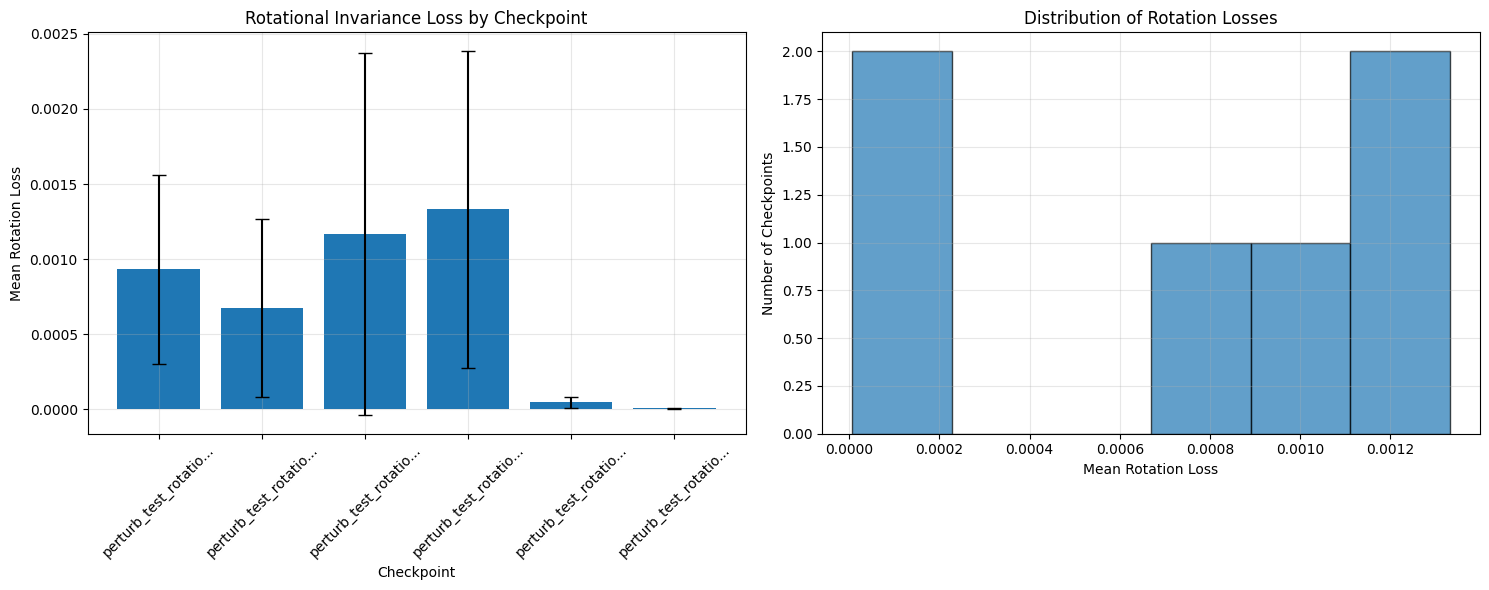


📊 Visualization saved as 'rotation_invariance_analysis.png'


In [20]:
# Optional: Quick visualization of results
if 'results_df' in locals() and len(results_df) > 0:
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Mean rotation loss by experiment
    ax1.bar(range(len(results_df)), results_df['mean_rotation_loss'], 
           yerr=results_df['std_rotation_loss'], capsize=5)
    ax1.set_xlabel('Checkpoint')
    ax1.set_ylabel('Mean Rotation Loss')
    ax1.set_title('Rotational Invariance Loss by Checkpoint')
    ax1.set_xticks(range(len(results_df)))
    ax1.set_xticklabels([name[:20] + '...' if len(name) > 20 else name 
                        for name in results_df['checkpoint_name']], rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Distribution of losses
    ax2.hist(results_df['mean_rotation_loss'], bins=min(10, len(results_df)), alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Mean Rotation Loss')
    ax2.set_ylabel('Number of Checkpoints')
    ax2.set_title('Distribution of Rotation Losses')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('rotation_invariance_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Visualization saved as 'rotation_invariance_analysis.png'")
else:
    print("⚠️ No results to visualize")

## 📋 Usage Summary

This notebook provides a complete pipeline for evaluating rotational invariance loss across multiple model checkpoints:

### **Key Features:**
- ✅ **Robust checkpoint loading** - Handles various checkpoint formats and missing parameters
- 🔄 **Configurable evaluation** - Customize number of rotations, test points, and sampling radius
- 📊 **Comprehensive statistics** - Mean, std, min, max, median rotation losses
- 💾 **Automatic saving** - Results exported to CSV for further analysis
- 📈 **Built-in visualization** - Bar plots and histograms of results

### **Key Parameters:**
- `n_rotations=100` - Number of random rotations to sample per evaluation
- `n_test_points=1000` - Number of test points sampled uniformly in circle
- `test_radius=2.0` - Radius of circle for sampling test points

### **Outputs:**
- `checkpoint_rotation_invariance_analysis.csv` - Detailed results for all checkpoints
- `rotation_invariance_analysis.png` - Visualization plots

### **Usage:**
1. Update `checkpoint_paths` list with your checkpoint files
2. Run all cells to evaluate rotational invariance
3. Results will be displayed and saved automatically


In [21]:
# Import Lie derivative regularizer
from regularizers import LieDerivativeRegularizer

def calculate_lie_derivative_loss(dynamics_fn, target_vector_field, n_test_points=1000, 
                                test_radius=2.0, device='cpu', random_seed=42, 
                                normalize_method=False):
    """
    Calculate Lie derivative loss for a dynamics function against a target vector field.
    
    Args:
        dynamics_fn: The learned dynamics function to evaluate
        target_vector_field: The target vector field (e.g., rotation field)
        n_test_points: Number of test points to sample
        test_radius: Radius for sampling test points
        device: Device for computation
        random_seed: Random seed for reproducibility
        normalize_method: Normalization method for LieDerivativeRegularizer
                         (False, True, "yang", or "new")
        
    Returns:
        mean_loss: Mean Lie derivative loss across all test points
        std_loss: Standard deviation of the loss
        all_losses: All individual loss values for detailed analysis
    """
    if random_seed is not None:
        torch.manual_seed(random_seed)
    
    # Create Lie derivative regularizer
    lie_regularizer = LieDerivativeRegularizer(
        f=dynamics_fn, 
        g=target_vector_field,
        normalize=normalize_method
    )
    
    # Sample test points uniformly within a circle
    # Use rejection sampling for uniform distribution in circle
    test_points = []
    while len(test_points) < n_test_points:
        # Sample in square then reject points outside circle
        candidates = test_radius * (2 * torch.rand(n_test_points * 2, 2, device=device) - 1)
        # Keep points within circle
        norms = torch.linalg.norm(candidates, dim=-1)
        valid_points = candidates[norms <= test_radius]
        test_points.append(valid_points)
        if len(test_points) > 10:  # Prevent infinite loop
            break
    
    test_points = torch.cat(test_points, dim=0)[:n_test_points]
    
    # Calculate Lie derivative loss
    with torch.no_grad():
        # eval_regularizer returns loss for each point
        point_losses = lie_regularizer.eval_regularizer(test_points)  # Shape: (n_test_points,)
        
        mean_loss = point_losses.mean().item()
        std_loss = point_losses.std().item()
        all_losses = point_losses.cpu().numpy()
    
    return mean_loss, std_loss, all_losses


def create_target_vector_fields():
    """Create common target vector fields for Lie derivative evaluation."""
    
    def rotation_field(x, omega=1.0):
        """Rotation vector field: f(x) = omega * (-y, x)"""
        return omega * torch.stack([-x[..., 1], x[..., 0]], dim=-1)
    
    def radial_field(x):
        """Radial outward field: f(x) = x"""
        return x
    
    def harmonic_oscillator(x, omega=1.0):
        """Harmonic oscillator: f(x) = omega^2 * (-x, -y)"""
        return -omega**2 * x
    
    def spiral_field(x, omega=1.0, gamma=0.1):
        """Spiral field: combination of rotation and radial"""
        rotation_part = omega * torch.stack([-x[..., 1], x[..., 0]], dim=-1)
        radial_part = gamma * x
        return rotation_part + radial_part
    
    return {
        'rotation_slow': lambda x: rotation_field(x, omega=0.5),
        'rotation_fast': lambda x: rotation_field(x, omega=2.0), 
        'radial_outward': radial_field,
        'harmonic_oscillator': harmonic_oscillator,
        'spiral_outward': lambda x: spiral_field(x, omega=1.0, gamma=0.1),
        'spiral_inward': lambda x: spiral_field(x, omega=1.0, gamma=-0.1)
    }


def evaluate_checkpoints_lie_derivative(checkpoint_paths, target_fields=None, 
                                       n_test_points=1000, test_radius=1.0,
                                       normalize_methods=[False, "yang", "new"],
                                       save_results=True, 
                                       results_filename='lie_derivative_results.csv'):
    """
    Evaluate Lie derivative loss for a list of checkpoints against multiple target fields.
    
    Args:
        checkpoint_paths: List of paths to checkpoint files
        target_fields: Dict of target vector fields (if None, uses default fields)
        n_test_points: Number of test points per evaluation
        test_radius: Radius for sampling test points
        normalize_methods: List of normalization methods to test
        save_results: Whether to save results to CSV
        results_filename: Filename for saved results
        
    Returns:
        results_df: DataFrame with results
    """
    if target_fields is None:
        target_fields = create_target_vector_fields()
    
    results = []
    
    total_evaluations = len(checkpoint_paths) * len(target_fields) * len(normalize_methods)
    current_eval = 0
    
    print(f"🔄 Evaluating Lie derivative loss for {len(checkpoint_paths)} checkpoints")
    print(f"   Against {len(target_fields)} target fields with {len(normalize_methods)} normalization methods")
    print(f"   Total evaluations: {total_evaluations}")
    print(f"   Using {n_test_points} test points within radius {test_radius}")
    print("="*80)
    
    for i, checkpoint_path in enumerate(checkpoint_paths):
        try:
            # Load dynamics function
            dynamics_fn, checkpoint_info = load_ssm_from_checkpoint(checkpoint_path, device=device)
            
            print(f"\n[{i+1:2d}/{len(checkpoint_paths)}] {Path(checkpoint_path).name}")
            print(f"         Experiment: {checkpoint_info['experiment_name']}")
            
            for field_name, target_field in target_fields.items():
                for norm_method in normalize_methods:
                    current_eval += 1
                    
                    try:
                        # Calculate Lie derivative loss
                        mean_loss, std_loss, all_losses = calculate_lie_derivative_loss(
                            dynamics_fn=dynamics_fn,
                            target_vector_field=target_field,
                            n_test_points=n_test_points,
                            test_radius=test_radius,
                            device=device,
                            normalize_method=norm_method
                        )
                        
                        # Store results
                        result = {
                            'checkpoint_path': checkpoint_path,
                            'checkpoint_name': Path(checkpoint_path).name,
                            'experiment_name': checkpoint_info['experiment_name'],
                            'epoch': checkpoint_info['epoch'],
                            'target_field': field_name,
                            'normalize_method': str(norm_method),
                            'mean_lie_loss': mean_loss,
                            'std_lie_loss': std_loss,
                            'min_lie_loss': np.min(all_losses),
                            'max_lie_loss': np.max(all_losses),
                            'median_lie_loss': np.median(all_losses),
                            'n_test_points': n_test_points,
                            'test_radius': test_radius
                        }
                        
                        results.append(result)
                        
                        print(f"         [{current_eval:3d}/{total_evaluations}] {field_name} (norm={norm_method}): {mean_loss:.6f} ± {std_loss:.6f}")
                        
                    except Exception as e:
                        print(f"         ❌ [{current_eval:3d}/{total_evaluations}] {field_name} (norm={norm_method}): Failed - {e}")
                        continue
            
        except Exception as e:
            print(f"❌ [{i+1:2d}/{len(checkpoint_paths)}] Failed to process {Path(checkpoint_path).name}: {e}")
            continue
        
        print("-" * 80)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    if len(results) > 0:
        print(f"\n📊 Summary of {len(results)} successful evaluations:")
        
        # Group by target field and normalization
        summary_stats = results_df.groupby(['target_field', 'normalize_method'])['mean_lie_loss'].agg(['mean', 'std', 'min', 'max'])
        print("\nBy target field and normalization method:")
        print(summary_stats)
        
        # Find overall best and worst
        best_idx = results_df['mean_lie_loss'].idxmin()
        worst_idx = results_df['mean_lie_loss'].idxmax()
        
        print(f"\n🏆 Overall best (lowest loss):")
        print(f"   Checkpoint: {results_df.loc[best_idx, 'checkpoint_name']}")
        print(f"   Target field: {results_df.loc[best_idx, 'target_field']}")
        print(f"   Normalization: {results_df.loc[best_idx, 'normalize_method']}")
        print(f"   Loss: {results_df.loc[best_idx, 'mean_lie_loss']:.6f}")
        
        print(f"\n🚨 Overall worst (highest loss):")
        print(f"   Checkpoint: {results_df.loc[worst_idx, 'checkpoint_name']}")
        print(f"   Target field: {results_df.loc[worst_idx, 'target_field']}")
        print(f"   Normalization: {results_df.loc[worst_idx, 'normalize_method']}")
        print(f"   Loss: {results_df.loc[worst_idx, 'mean_lie_loss']:.6f}")
        
        # Save results
        if save_results:
            results_df.to_csv(results_filename, index=False)
            print(f"\n💾 Results saved to: {results_filename}")
    else:
        print("❌ No successful evaluations!")
    
    return results_df


print("🔧 Lie derivative analysis functions defined:")
print("   - calculate_lie_derivative_loss(): Compute Lie derivative loss against target field")
print("   - create_target_vector_fields(): Generate common target vector fields")  
print("   - evaluate_checkpoints_lie_derivative(): Batch evaluate multiple checkpoints")

🔧 Lie derivative analysis functions defined:
   - calculate_lie_derivative_loss(): Compute Lie derivative loss against target field
   - create_target_vector_fields(): Generate common target vector fields
   - evaluate_checkpoints_lie_derivative(): Batch evaluate multiple checkpoints


In [24]:
# Example: Evaluate Lie derivative loss for your checkpoints
if len(existing_paths) > 0:
    print("🎯 Testing Lie derivative analysis with rotation field...")
    
    # Quick test with just rotation field and basic normalization
    target_fields = {
        'rotation_1.0': lambda x: 0.5 * torch.stack([-x[..., 1], x[..., 0]], dim=-1),
        # 'radial_outward': lambda x: x
    }
    
    lie_results_df = evaluate_checkpoints_lie_derivative(
        existing_paths[:6],  # Test with first 3 checkpoints
        target_fields=target_fields,
        normalize_methods=["yang"],  # Test 2 normalization methods
        n_test_points=1000,  # Smaller sample for faster testing
        test_radius=1.0,
        save_results=True,
        results_filename='lie_derivative_test_results.csv'
    )
    
    # Display results
    if len(lie_results_df) > 0:
        print("\n📋 Lie Derivative Results:")
        display_cols = ['checkpoint_name', 'target_field', 'normalize_method', 
                       'mean_lie_loss', 'std_lie_loss']
        print(lie_results_df[display_cols].to_string(index=False))
        
        # Show which checkpoint/target/normalization combo works best
        best_combo = lie_results_df.loc[lie_results_df['mean_lie_loss'].idxmin()]
        print(f"\n🏆 Best combination:")
        print(f"   Checkpoint: {best_combo['checkpoint_name']}")
        print(f"   Target field: {best_combo['target_field']}")
        print(f"   Normalization: {best_combo['normalize_method']}")
        print(f"   Lie loss: {best_combo['mean_lie_loss']:.6f}")
        
else:
    print("⚠️ No checkpoints available for Lie derivative analysis")

🎯 Testing Lie derivative analysis with rotation field...
🔄 Evaluating Lie derivative loss for 6 checkpoints
   Against 1 target fields with 1 normalization methods
   Total evaluations: 6
   Using 1000 test points within radius 1.0
✅ Loaded model from perturb_test_rotation_lambda_0_00e00_final_epoch_025.pt

[ 1/6] perturb_test_rotation_lambda_0_00e00_final_epoch_025.pt
         Experiment: perturb_test_rotation_lambda_0_00e00
         [  1/6] rotation_1.0 (norm=yang): 0.004981 ± 0.061184
--------------------------------------------------------------------------------
✅ Loaded model from perturb_test_rotation_lambda_1_00eneg05_final_epoch_025.pt

[ 2/6] perturb_test_rotation_lambda_1_00eneg05_final_epoch_025.pt
         Experiment: perturb_test_rotation_lambda_1_00eneg05
         [  2/6] rotation_1.0 (norm=yang): 0.002622 ± 0.013932
--------------------------------------------------------------------------------
✅ Loaded model from perturb_test_rotation_lambda_1_00eneg03_final_epoch_025